### Batch Generator for Object Detection Raccoon Detection

#### Problema:

* 2 arquivos .csv de dados contendo imagens, tamanho e anotação de boundingbox. 
* Imagens de Guaxinins de tamanhos diferentes.
* Agregar pipeline de transformação de imagens.
* Gerar um BatchGenerator para evitar carregar todas as imagens na memória.
 

In [9]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Sequence

#### Load image and annotation path

In [10]:
dataset_path = "C:/Users/BOM5CA/Documents/Palestras_e_Cursos/Treinamento AI Aplicada ICo/Material/dataset/obj_detection"
images_path = os.path.join(dataset_path, "images")
annotation_trn = os.path.join(dataset_path, "train_labels.csv")
annotation_tst = os.path.join(dataset_path, "test_labels.csv")
batch_size = 8


#### Set up Batch Generator

In [11]:

class BatchGenerator(Sequence):

    def __init__(self, images_path, annotations_path, input_shape, batch_size=16, shuffle=True, jitter=True, debug=False):

        self._images_path = images_path
        self._annotations_path = annotations_path

        self._input_shape = input_shape

        self._batch_size = batch_size
        self._shuffle = shuffle
        self._jitter = jitter
        self._debug = debug

        self._images = []
        self._labels = {}
        self._samples_per_label = {}

        skip_header = True

        with open(self._annotations_path, "r") as af:
            for line in af:
                if skip_header:
                    skip_header = False
                    continue
                filename, width, height, label, xmin, ymin, xmax, ymax = line.strip().split(",")


                image = {
                    "filename": filename,
                    "label": label,
                    "bbox": [int(xmin), int(ymin), int(xmax), int(ymax)],
                    "shape": (int(width), int(height))
                }

                # Contar imagens por label
                if label not in self._samples_per_label:
                    self._samples_per_label[label] = 1
                else:
                    self._samples_per_label[label] += 1

                # Id em labels categoricos
                if label not in self._labels:
                    self._labels[label] = len(self._labels)

                self._images.append(image)

            print(f"Foram encontradas {len(self._labels)} classes")
            for lbl, id in self._labels.items():
                print(f'Classe {lbl}({id}) com {self._samples_per_label[lbl]} imagens')


        ## Fazer pipeline de augmentation [exercicio]
        self._aug_pipe = None


        if shuffle:
            np.random.shuffle(self._images)

    def __len__(self):
        ## retorna o número de batches
        return int(np.ceil(len(self._images) / self._batch_size))

    def num_classes(self):
        return len(self._labels)

    def size(self):
        return len(self._images)

    def __getitem__(self, idx):
        # Carrega todos os item de um batch para processamento
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images):
            r_bound = len(self._images)
            l_bound = r_bound - self._config['BATCH_SIZE']

        instance_count = 0

        w, h = self._input_shape
        x_batch = np.zeros((r_bound - l_bound, h, w, 3))

        if len(self._labels) > 2:
            y_batch = np.zeros((r_bound - l_bound, len(self._labels)))
        else:
            y_batch = np.zeros((r_bound - l_bound, 1))

        for train_instance in self._images[l_bound:r_bound]:

            # augment input image and fix object's position and size
            img = self.aug_image(train_instance, instance_count, w, h, jitter=self._jitter)

            # assign input image to x_batch
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=0)
            x_batch[instance_count] = img

            if len(self._labels) > 2:
                y = np.zeros(len(self._labels))
                y[train_instance['label']] = 1.0
            else:
                y = np.zeros(1)
                y[0] = self._labels[train_instance['label']]
            y_batch[instance_count] = y

            # increase instance counter in current batch
            instance_count += 1

        return x_batch, y_batch

    def aug_image(self, train_instance, instance_count, width, height, jitter):

        image_name = train_instance['filename']
        image = cv2.imread(os.path.join(self._images_path, image_name))

        # resize image
        image = cv2.resize(image, (width, height))

        # Fazer resize bounding box [exercicio]
        xmin, ymin, xmax, ymax = train_instance['bbox']
        old_w, old_h = train_instance['shape']
        
        if jitter:
            pass

        train_instance['bbox'] = [int(xmin), int(ymin), int(xmax), int(ymax)]

        if self._debug:
            self._show_debug(image, train_instance['bbox'])

        # normalize image
        image = image/255.0

        return image

    def on_epoch_end(self):
        # No final de cada época, as imagens são embaralhadas novamente
        if self._shuffle:
            np.random.shuffle(self._images)

    def _show_debug(self, image, bbox):
        """
        Função para mostrar imagens transformadas pelo batch generator aug_pipe
        :param image: imagem
        :param bbox: bounding box of image
        """
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.rectangle(image, tuple(bbox[:2]), tuple(bbox[2:]), (0, 255, 0))
        plt.axis('off')
        plt.imshow(image)
        plt.show()

    @property
    def labels(self):
        return self._labels

    @property
    def samples_per_label(self):
        return self._samples_per_label

    @property
    def jitter(self):
        return self._jitter

    @property
    def shuffle(self):
        return self._shuffle

    @property
    def debug(self):
        return self._debug

    @debug.setter
    def debug(self, new_state):
        self._debug = new_state

#### Visualização de imagens

In [12]:
def view_samples(generator, times=1):
    generator.debug = True
    iter_generator = iter(generator)
    
    for i in range(times):
        _ = next(iter_generator)

#### Definir gerados para ambos os datasets treino/teste


In [13]:
train_generator = BatchGenerator(images_path,
                                 annotation_trn,
                                 input_shape=(112, 112),
                                 batch_size=8,
                                 shuffle=True,
                                 jitter=True,
                                 debug=False)

test_generator = BatchGenerator(images_path,
                                annotation_tst,
                                input_shape=(112, 112),
                                batch_size=8,
                                shuffle=False,
                                jitter=False,
                                debug=False)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/BOM5CA/Documents/Palestras_e_Cursos/Treinamento AI Aplicada ICo/Material/dataset/obj_detection\\train_labels.csv'

Visualizar imagens


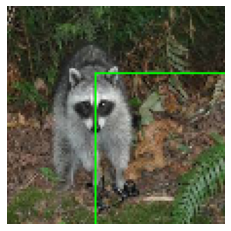

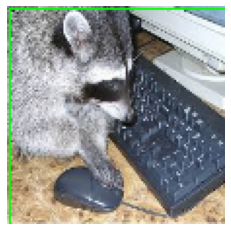

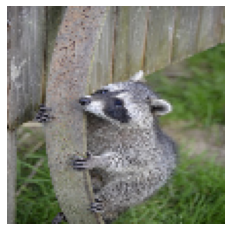

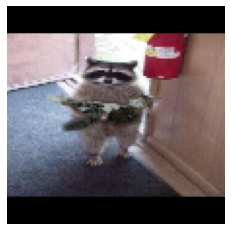

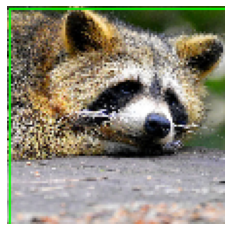

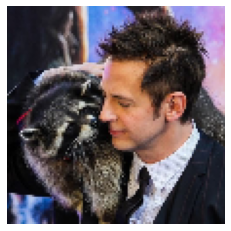

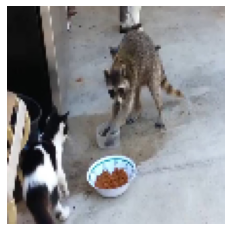

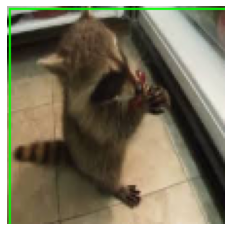

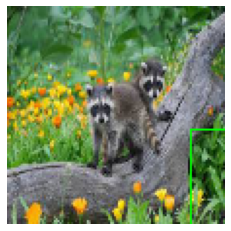

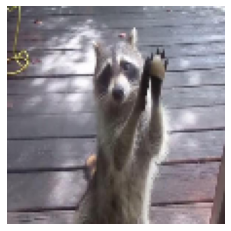

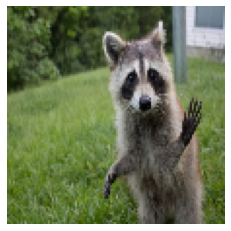

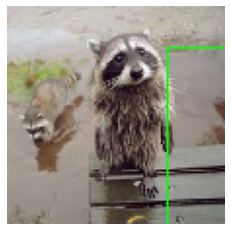

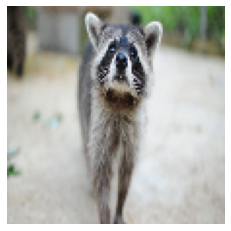

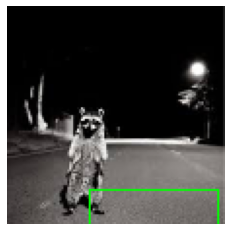

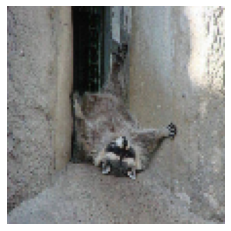

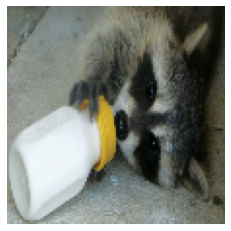

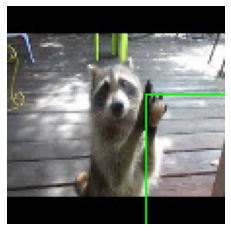

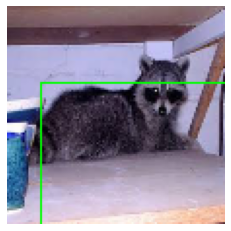

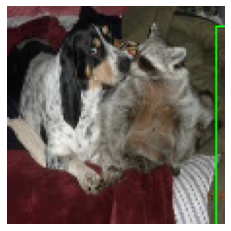

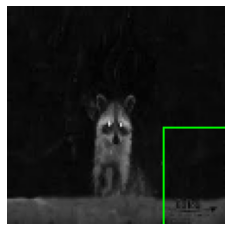

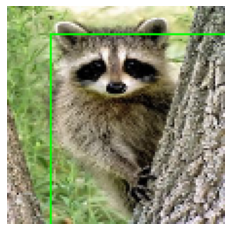

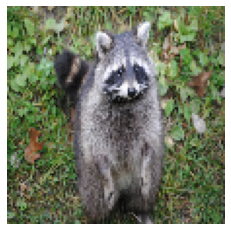

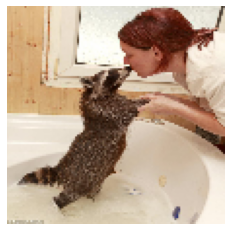

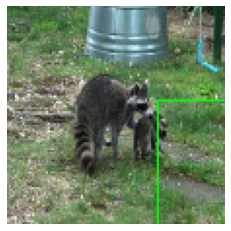

In [ ]:
view_samples(train_generator, 3)


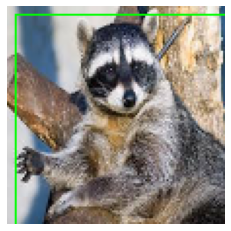

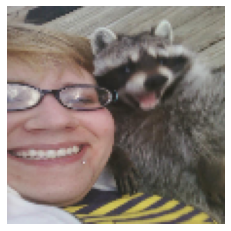

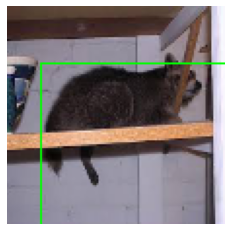

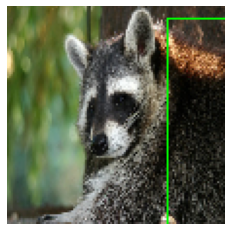

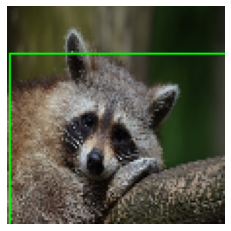

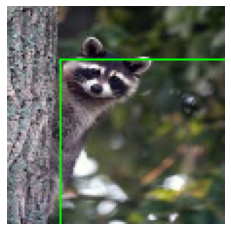

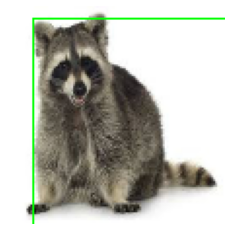

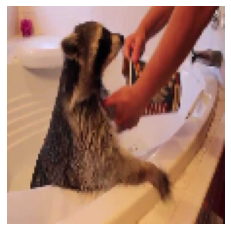

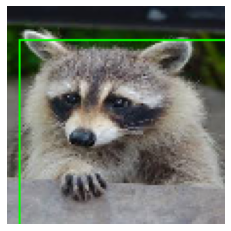

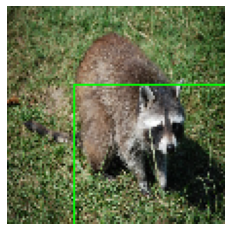

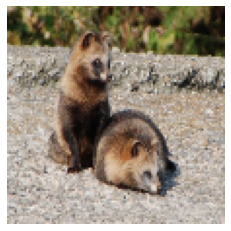

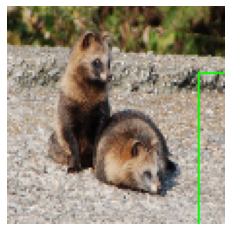

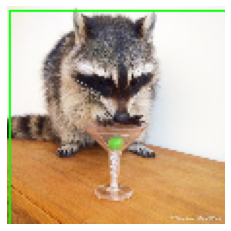

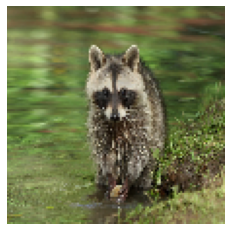

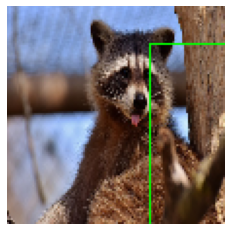

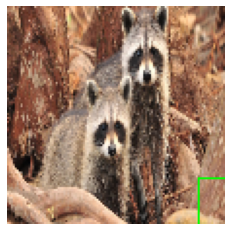

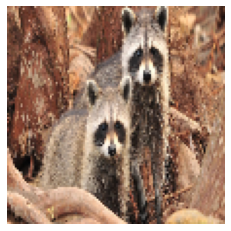

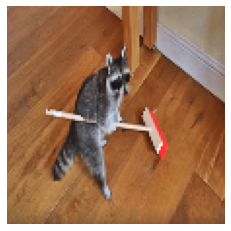

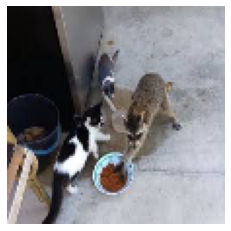

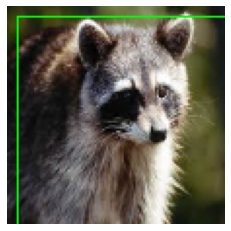

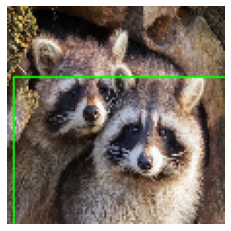

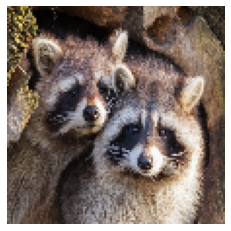

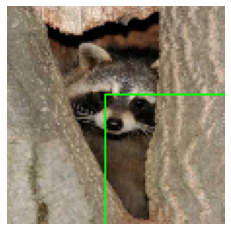

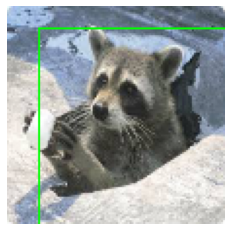

In [ ]:
view_samples(test_generator, 3)